<a href="https://colab.research.google.com/github/ahmed-dev-tech/Speech_to_text/blob/main/Word_to_Text_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# change to working tensorflow directory on the drive
%cd '/content/gdrive/MyDrive/word_data'

Mounted at /content/gdrive
/content/gdrive/MyDrive/word_data


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c tensorflow-speech-recognition-challenge

In [ ]:
!7z x train.7z -okaggle_original_data

In [ ]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
import pandas as pd
%matplotlib inline
import librosa.display
from scipy.signal import butter, lfilter, freqz

warnings.filterwarnings("ignore")


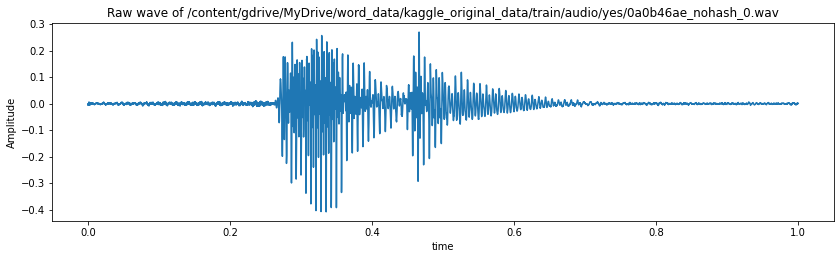

In [ ]:
train_audio_path = '/content/gdrive/MyDrive/word_data/kaggle_original_data/train/audio'
sample, sample_rate = librosa.load(train_audio_path+'/seven/0a0b46ae_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '/content/gdrive/MyDrive/word_data/kaggle_original_data/train/audio/yes/0a0b46ae_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(sample), sample_rate), sample)

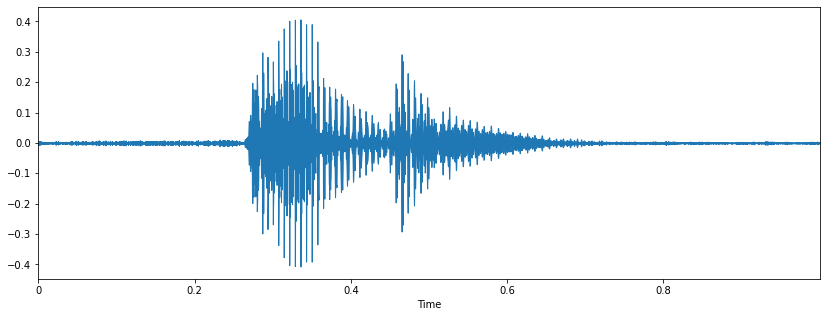

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(sample, sr=sample_rate)

In [ ]:
ipd.Audio(sample, rate=sample_rate)

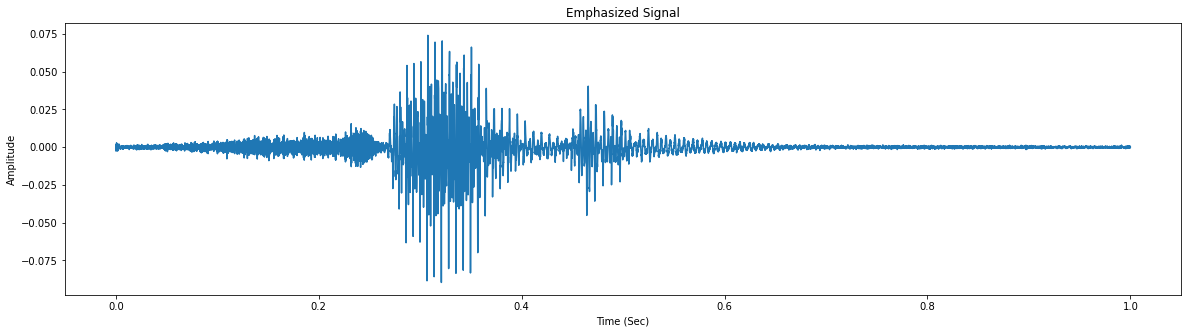

In [ ]:
#PreEmphasis
pre_emphasis = 1
emphasized_signal = np.append(sample[0], sample[1:] - pre_emphasis * sample[:-1])
Time=np.linspace(0, len(emphasized_signal)/sample_rate, num=len(emphasized_signal))
#PreEmphasis Graph
plt.figure(figsize=(20,5))
plt.plot(Time,emphasized_signal)
plt.title('Emphasized Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

In [ ]:
#PreEmphasis Audio results
ipd.Audio(emphasized_signal, rate=sample_rate)

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    #  Cutoff: cutoff frequency
    #  Fs sampling rate
    nyq = 0.5 * fs                     #  Signal frequency
    normal_cutoff = cutoff / nyq    #  Normal cutoff frequency = cutoff frequency / signal frequency
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y  # Filter requirements.



order = 6
fs = sample_rate                                       #  Sampling rate, Hz
cutoff = 5000                    #  The desired cutoff frequency of the filter, Hz # gets the filter coefficient so that we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)         #  Draw frequency response
w, h = freqz(b, a)

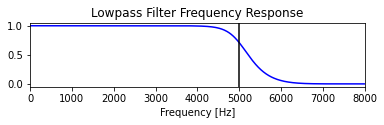

In [ ]:
plt.subplot(3, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
   
filtered_signal = butter_lowpass_filter(emphasized_signal, cutoff, fs, order)

plt.show()

In [ ]:
ipd.Audio(filtered_signal, rate=sample_rate)

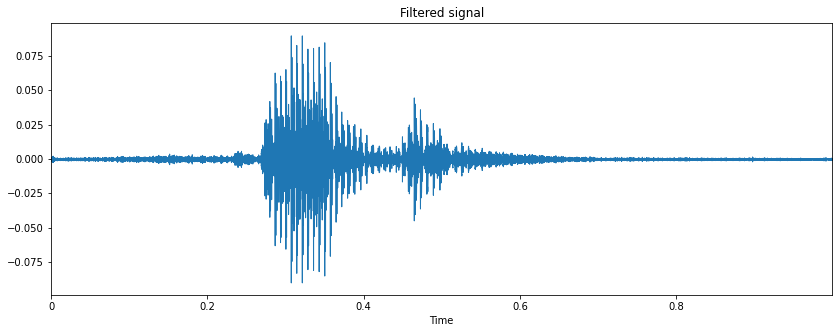

In [ ]:
#Filtered signal
plt.figure(figsize=(14, 5))
plt.title("Filtered signal")
librosa.display.waveplot(filtered_signal, sr=sample_rate)

In [ ]:
y = librosa.effects.split(filtered_signal,top_db=30)
l = []
for i in y:
    l.append( filtered_signal[i[0]:i[1]] )
filtered_signal = np.concatenate(l,axis=0)
Time=np.linspace(0, len(filtered_signal)/sample_rate, num=len(filtered_signal))

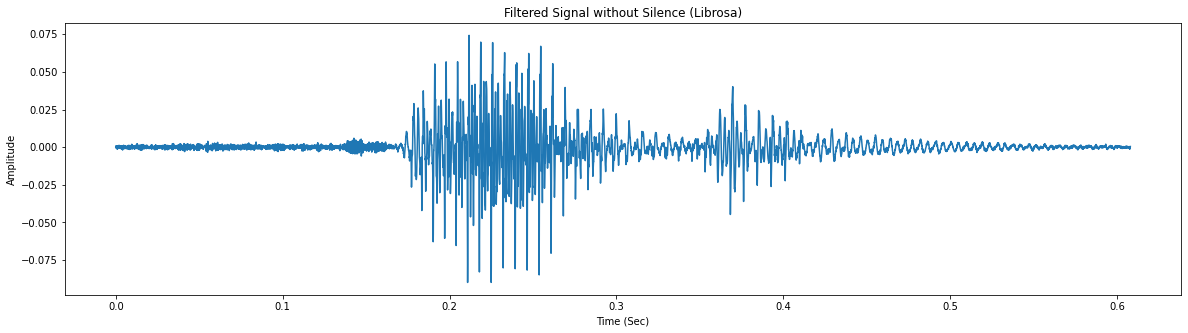

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Time,filtered_signal)
plt.title('Filtered Signal without Silence (Librosa)')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

In [ ]:
ipd.Audio(filtered_signal, rate=sample_rate)

In [ ]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(filtered_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(filtered_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=True)]
#Framming done

In [ ]:
sample_rate

16000

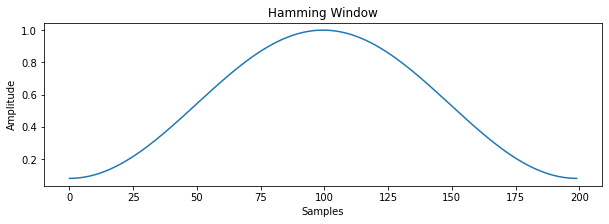

In [ ]:
#Windowing ==> i use hamming windowing 
#formulated as w[n]=0.54−0.46cos(2πnN−1) . where 0≤n≤N−1
#setting for humming
x = np.hamming(200)
#plot humming (remove later)
plt.figure(figsize=(10,3))
plt.plot(x)
plt.title('Hamming Window')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.show()

In [ ]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT

In [ ]:
len(mag_frames)

59

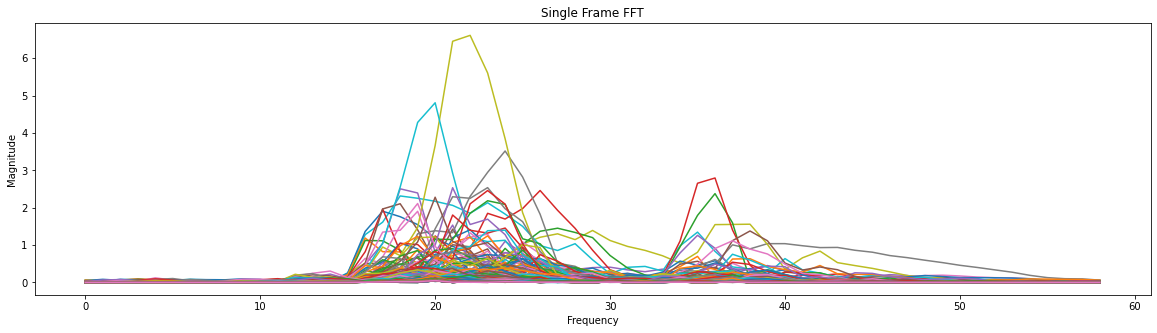

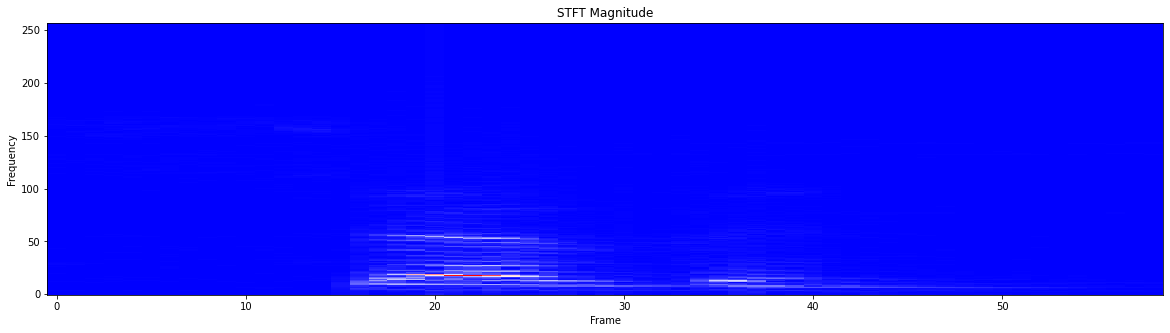

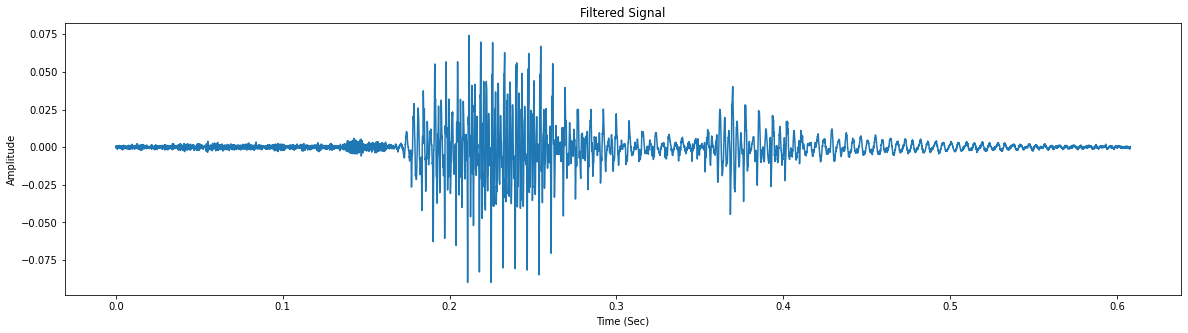

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(mag_frames)
plt.title("Single Frame FFT")
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

fig, ax = plt.subplots(figsize=(20,5))
cax = ax.imshow(mag_frames.T, interpolation='nearest', cmap= plt.cm.bwr, origin='lower', aspect='auto')
plt.title("STFT Magnitude")
plt.xlabel('Frame')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(Time,filtered_signal)
plt.title('Filtered Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (Sec)')
plt.show()

In [ ]:
# Time=np.linspace(0, len(emphasized_signal)/sample_rate, num=len(emphasized_signal))
# plt.figure(figsize=(20,5))
# plt.plot(Time,emphasized_signal)
# plt.title('Emphasized Signal')
# plt.ylabel('Amplitude')
# plt.xlabel('Time (Sec)')
# plt.show()

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(samples, sr=sample_rate)
ax.label_outer()

## Feature Extraction

In [ ]:
sample_rate = 16000
def mfcc_feature(audio):
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
 
    return mfcc   # it returns a np.array with size (40,'n') where n is the number of audio frames.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
img = librosa.display.specshow(data, x_axis='time', ax=ax)
ax.set(title='MFCC')
ax.label_outer()

In [ ]:
def RMS_feature(audio):
    rms = librosa.feature.rms(y=audio)
 
    return rms   # it returns a np.array with size (1,'n') where n is the number of audio frames.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

times = librosa.times_like(data)
ax.semilogy(times, data[0], label='RMS Energy')
ax.set(xticks=[])
ax.legend()
ax.label_outer()

In [ ]:
sample_rate = 16000
def CEN_feature(audio):
    cen = librosa.feature.chroma_cens(y=audio, sr=sample_rate)
 
 
    return cen   # it returns a np.array with size (12,'n') where n is the number of audio frames.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

img = librosa.display.specshow(data, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='chroma_cen')

ax.label_outer()

In [ ]:
sample_rate = 16000
def melspectrogram_feature(audio):
    melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=2048)
 
    return melspectrogram   # it returns a np.array with size (128,'n') where n is the number of audio frames.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

S_dB = librosa.power_to_db(data, ref=np.max)

img = librosa.display.specshow(S_dB, x_axis='time',

                         y_axis='mel', sr=16000,

                         fmax=8000, ax=ax)


ax.set(title='Mel-frequency spectrogram')
ax.label_outer()

In [ ]:
sample_rate = 16000
def spectral_centroid_feature(audio):
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate, n_fft=2048)
 
    return spectral_centroid   # it returns a np.array with size (1,'n') where n is the number of audio frames.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

times = librosa.times_like(data)
ax.plot(times, data.T, label='Spectral Centroid')

ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')
ax.label_outer()

In [ ]:
sample_rate = 16000
def tonnetz_feature(audio):
  
    y = librosa.effects.harmonic(audio)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sample_rate)
 
    return tonnetz   # it returns a np.array with size (6,'n') where n is the number of audio frames.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))


img = librosa.display.specshow(data, y_axis='tonnetz', x_axis='time', ax=ax)

ax.set(title='Tonal Centroids (Tonnetz)')
ax.label_outer()

In [ ]:
sample_rate = 16000
def spectral_contrast_feature(audio):
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate, n_fft=2048)
 
    return spectral_contrast   # it returns a  np.array with size (1,'n') where n is the number of audio frames.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

times = librosa.times_like(data)

ax.plot(times, data[0], label='Spectral Contrast')

ax.set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])

ax.legend()

ax.label_outer()

In [ ]:
sample_rate = 16000
def poly_feature(audio):
    poly_features = librosa.feature.poly_features(y=audio, sr=sample_rate, n_fft=2048)
 
    return poly_features   # it returns a np.array with size (2,'n') where n is the number of audio frames.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

times = librosa.times_like(data)

ax.plot(times, data[1].T, alpha=0.8, label='Poly Feature')
ax.legend()
ax.label_outer()

In [ ]:
sample_rate = 16000
def spectral_rolloff_feature(audio):
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate,  roll_percent=0.95)
 
    return spectral_rolloff   # it returns a np.array with size (1,'n') where n is the number of audio frames.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

times = librosa.times_like(data)

ax.plot(times, data[0],  label='roll-off frequency')

ax.legend()
ax.label_outer()

In [ ]:
sample_rate = 16000
def chroma_stft_feature(audio):
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_fft=2048)
 
    return chroma_stft   # it returns a np.array with size (12,'n') where n is the number of audio frames.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

img = librosa.display.specshow(data, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='Chromagram')
ax.label_outer()

In [ ]:
#feature extraction done

In [ ]:
#resampling
samples = librosa.resample(mag_frames, sample_rate, 8000)
ipd.Audio(mag_frames, rate=8000) 

In [ ]:
#importError
import os
labels=os.listdir(train_audio_path)

In [ ]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
#print no_of_recordings
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [ ]:
labels=["down", "bed", "cat"]

In [ ]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [ ]:
all_wave = []
all_label = []
for label in labels:
    #print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

In [ ]:
#printing all labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
print(classes)

In [ ]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
print(y)

In [ ]:
for i in range(len(y)):
  print(y)

In [ ]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)
#OCN implimentation
reject_output = keras.layers.Dense(1, activaton="sigmoid", name="reject_layer")(conv)
classification_output = keras.layers.Dense(len(labels), activaton="softmax", name="reject_layer")(conv)

model = Model(inputs, outputs=[reject_output, classification_output])#outputs)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
242/242 [==============================] - 55s 228ms/step - loss: 0.8825 - accuracy: 0.5757 - val_loss: 0.6574 - val_accuracy: 0.7214
Epoch 2/100
242/242 [==============================] - 55s 226ms/step - loss: 0.5724 - accuracy: 0.7722 - val_loss: 0.5923 - val_accuracy: 0.7747
Epoch 3/100
242/242 [==============================] - 54s 224ms/step - loss: 0.4585 - accuracy: 0.8258 - val_loss: 0.4112 - val_accuracy: 0.8488
Epoch 4/100
242/242 [==============================] - 54s 225ms/step - loss: 0.3959 - accuracy: 0.8494 - val_loss: 0.4256 - val_accuracy: 0.8498
Epoch 5/100
242/242 [==============================] - 54s 222ms/step - loss: 0.3208 - accuracy: 0.8791 - val_loss: 0.3372 - val_accuracy: 0.8752
Epoch 6/100
242/242 [==============================] - 54s 221ms/step - loss: 0.2973 - accuracy: 0.8906 - val_loss: 0.4202 - val_accuracy: 0.8307
Epoch 7/100
242/242 [==============================] - 54s 222ms/step - loss: 0.2583 - accuracy: 0.9009 - val_loss: 0.3474 -

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: ignored

In [ ]:
from keras.models import load_model
model=load_model('best_model.hdf5')

In [ ]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [ ]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

In [ ]:
print("Text:",predict(samples))

In [ ]:
os.listdir('../input/voice-commands/prateek_voice_v2')

In [ ]:
filepath='../input/voice-commands/prateek_voice_v2'

In [ ]:
#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'stop.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)

In [ ]:
#converting voice commands to text
predict(samples)

In [ ]:
#KNN
knn = neighbors.KNeighborsClassifier(18, weights='distance')
knn.fit(x_tr, y_tr)
y_pred = knn.predict(x_val)
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
accuracy_knn = accuracy_score(y_val, y_pred)
print("\nAccuracy: ", accuracy_knn)
print("\nPrecision: ", precision_score(y_val, y_pred))
print("\nRecall: ", recall_score(y_val, y_pred))

In [ ]:
#SVM
from sklearn import svm
svc = svm.SVC(kernel='poly', gamma='auto')
svc.fit(x_tr, y_val)
y_pred = svc.predict(x_val)
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
accuracy_svm = accuracy_score(y_val, y_pred)
print("\nAccuracy: ", accuracy_svm)
print("\nPrecision: ", precision_score(y_val, y_pred))
print("\nRecall: ", recall_score(y_val, y_pred))

In [ ]:
#SVR 

In [ ]:
#LSTM
embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2500, embed_dim,input_length = X.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

In [ ]:
Y = pd.get_dummies(data['sentiment']).values
#Here we train the Network.
model.fit(x_tr, y_tr, batch_size =batch_size, nb_epoch = 1,  verbose = 5)

In [ ]:
#LSTM Accuracy
model.evaluate(x_val,y_val,verbose=2,batch_size=batch_size)